# Project description

This report comes to investigate user behavior in the company's app that sells food products.

First we will check the sales funnel, in order to find important information on the users behavior in the app.

Then we will examine the results of an A/A/B test that checks the impact of changing the fonts for the entire app on the user behavior, in order to determine which set of fonts produces better results.

# Description of the data

•	EventName — event name

•	DeviceIDHash — unique user identifier

•	EventTimestamp — event time

•	ExpId — experiment number: 246 and 247 are the control groups, 248 is the test group.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import datetime as dt
from statsmodels.stats.weightstats import ztest as ztest

In [2]:
try:
    logs = pd.read_csv('C:/Users/ASUS/OneDrive/Desktop/projcts files/logs_exp_us.csv' ,sep="\s+")
except:
    logs = pd.read_csv('/datasets/logs_exp_us.csv',sep="\s+") 

# Prepare the data for analysis 

1.changing the columns name to make the data more clear

2.checking for missing data - there is no missing data

3.checking for duplicated users in A/A/B test groups- there is no duplicated users in the tests groups.

4.checking for duplicate rows- there are 413 duplicated rows after examning them we see they spread all a cross the different events and the A/A/B test groups and time stamps , what means they are probably out of mistake in the regstriy on the server, so i decided to take them off.

In [3]:
logs.columns=['event name','user id','time stamp','exp id']

In [4]:
logs['time']=pd.to_datetime(logs['time stamp'],unit='s')
logs['date']=logs['time'].dt.date

In [5]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event name  244126 non-null  object        
 1   user id     244126 non-null  int64         
 2   time stamp  244126 non-null  int64         
 3   exp id      244126 non-null  int64         
 4   time        244126 non-null  datetime64[ns]
 5   date        244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


In [6]:
logs.head()

,event name,user id,time stamp,exp id,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [7]:
logs.isnull().sum()

event name    0
user id       0
time stamp    0
exp id        0
time          0
date          0
dtype: int64

In [8]:
check_id=logs.groupby(['user id'])['exp id'].nunique().reset_index()
check_id[check_id['exp id']>1]

,user id,exp id


In [9]:
logs.duplicated().sum()

413

In [10]:
for i in logs[logs.duplicated()].columns:
    print(i,':', logs[logs.duplicated()][i].nunique())

event name : 5
user id : 237
time stamp : 352
exp id : 3
time : 352
date : 9


In [11]:
logs[logs.duplicated()]['time'].dt.date.unique()

array([datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 3), datetime.date(2019, 8, 4),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7)], dtype=object)

In [12]:
logs=logs.drop_duplicates()

# Checking the data 

#### Number of events  in the logs 

In [13]:
print('there are',logs['event name'].count(), 'events in the logs')

there are 243713 events in the logs


#### Number of users in the logs

In [14]:
print('there are',logs['user id'].nunique(), 'users in the logs')

there are 7551 users in the logs


####  The average number of events per user

In [15]:
m_event=logs.groupby('user id').agg({'event name': 'nunique'}).mean()
print('the average number of events per user is ',int(m_event))

the average number of events per user is  2


#### Period of time the data cover 

In [16]:
logs['time'].max()
logs['time'].min()

Timestamp('2019-08-07 21:15:17')

Timestamp('2019-07-25 04:43:36')

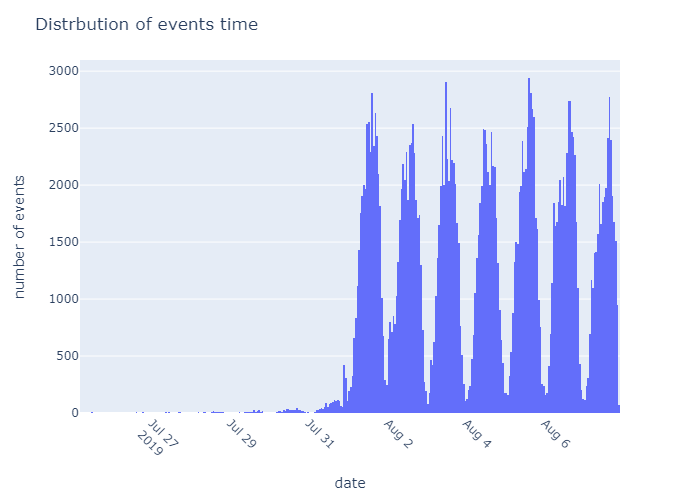

In [17]:
fig = px.histogram(logs, x="time")
fig.update_layout(title='Distrbution of events time',
                   xaxis_title='date',
                   yaxis_title='number of events')
fig.update_xaxes(tickangle=45)
fig.show("png");

#### Slicing the data by the relevant event time 

we can see from the histogram the data actually represent events from 31/7/2019 and further.

out of that i decided to slice the data from this date to make the data more acurrate.

after the slice of the data we can see that the data size changed a bit.

the number of lost events after slicing the data is:  796  that is  0.327 % loss.

the number of lost users after slicing the data is:  9  that is  0.119 % loss.

In [18]:
mask = (logs['time'] > '2019-07-31') 
logs_new = logs.loc[mask]

In [19]:
logs_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242917 entries, 797 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event name  242917 non-null  object        
 1   user id     242917 non-null  int64         
 2   time stamp  242917 non-null  int64         
 3   exp id      242917 non-null  int64         
 4   time        242917 non-null  datetime64[ns]
 5   date        242917 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


#### New period of time the data cover 

In [20]:
logs_new['time'].max()
logs_new['time'].min()

Timestamp('2019-08-07 21:15:17')

Timestamp('2019-07-31 01:11:46')

#### Checking there are users from all three experimental groups. 

In [21]:
users_loss=logs['user id'].nunique()- logs_new['user id'].nunique()
event_loss=logs['exp id'].count() - logs_new['exp id'].count()
per_users=round(users_loss/ logs['user id'].nunique() *100,3)
per_event= round(event_loss/ logs['exp id'].count() * 100,3)
user_check=logs_new.groupby(['exp id']).agg({'user id': 'nunique'}).reset_index().sort_values(by='user id', ascending=False)
user_check.columns=['experment id','number of users']
user_check
print()
print(' number of lost events after slicing the data is: ',event_loss, ' that is ',per_event,'% loss')
print()
print(' number of lost users after slicing the data is: ',users_loss, ' that is ',per_users, '% loss' )

,experment id,number of users
2,248,2540
1,247,2517
0,246,2485



 number of lost events after slicing the data is:  796  that is  0.327 % loss

 number of lost users after slicing the data is:  9  that is  0.119 % loss


# Study the event funnel

#### what events are in the logs and their frequency of occurrence

In [22]:
logs_new['event name'].value_counts()

MainScreenAppear           118578
OffersScreenAppear          46707
CartScreenAppear            42560
PaymentScreenSuccessful     34058
Tutorial                     1014
Name: event name, dtype: int64

#### The number of users who performed each of these actions

From the table we can see the amount of users who preform each action out of all users. 

The sequence seems like a single sequence in this order "Main Screen Appear"--- "Offers Screen Appear"--- "Cart Screen Appear"
--- "Payment Screen Successful".

The tutorial action seems to be out of the single sequence , because the purchase could take place with out it. 

Out of that i decided to take the tutorial action out of the funnel calculation.


In [23]:
user_per=logs_new.groupby(['event name']).agg({'user id': 'nunique'}).reset_index().sort_values(by='user id', ascending=False)
user_per.columns=['event name','number of users']
user_per['% from all users']=round(user_per['number of users']/logs_new['user id'].nunique() *100,2)
user_per

,event name,number of users,% from all users
1,MainScreenAppear,7429,98.50
2,OffersScreenAppear,4606,61.07
0,CartScreenAppear,3742,49.62
3,PaymentScreenSuccessful,3542,46.96
4,Tutorial,845,11.20


#### Sequence of events

We can see that 2875 users only got to "Main Screen Appear" event, and 868 only got to "Main Screen Appear" -- "Offers Screen Appear". 

When we check the users that went in all the Sequence of events we can see the most common Sequence is "Main Screen Appear" -- "Offers Screen Appear"-- "Cart Screen Appear" -- "Payment Screen Successful".

In [24]:
sorted_data=logs_new[logs_new['event name']!='Tutorial'].sort_values(by=['user id','time'])

In [25]:
def sequence(user):
    sorted_user=sorted_data[sorted_data['user id']==user].sort_values(by=['user id','time'])
    return sorted_user['event name'].drop_duplicates().to_list()

In [26]:
sequence_empty=[]
for i in sorted_data['user id'].unique():
    sequence_empty.append([i,sequence(i)])

In [27]:
path_data=pd.DataFrame(sequence_empty,columns=['user','path'])
path_data['path'] = [','.join(map(str, l)) for l in path_data['path']]
seq=path_data.groupby('path').agg({'user': 'nunique'}).reset_index().sort_values(by='user', ascending=False)
pd.options.display.max_colwidth = 210
seq.head()

,path,user
12,MainScreenAppear,2875
20,"MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful",870
18,"MainScreenAppear,OffersScreenAppear",868
21,"MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,CartScreenAppear",714
23,"MainScreenAppear,PaymentScreenSuccessful,CartScreenAppear,OffersScreenAppear",607


#### The share of users that proceed from each stage to the next

From the funnel diagram we can see the share of users that proceed from each stage to the next.

Out of that we see that on the "Offers Screen Appear" we lose most of our users (38%  of the users), so it needs further investagtion to figure out what make the user leave between this stages.

We can see that 47.7% of the users make the entire journey from "Main Screen Appear" event to payment.

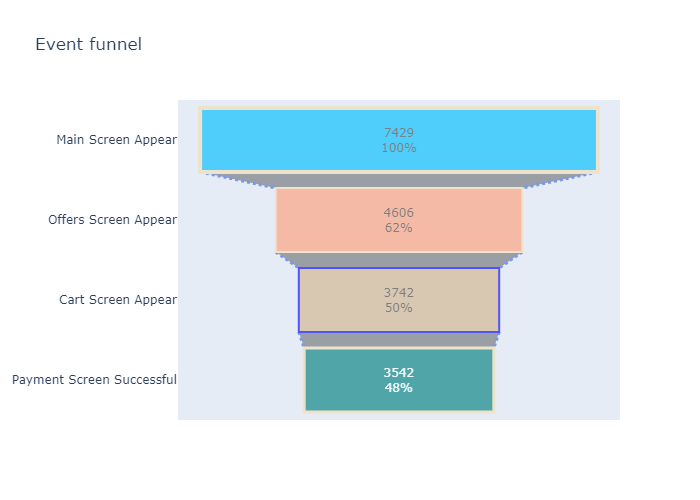

In [28]:
fig = go.Figure(go.Funnel(
    y = ["Main Screen Appear", "Offers Screen Appear", "Cart Screen Appear", "Payment Screen Successful"],
    x = [7429, 4606, 3742, 3542],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}))
fig.update_layout(
    title="Event funnel ") 
fig.show("png");

# Study the results of the A/A/B test

#### Checking if there is a statistically significant difference between the A/A groups.

H0 (Null):my null hypothesis (H₀) is that the conversion proportions of group A 246 and group A 247 are equal.

H1 (Alternative):my alternative hypothesis, (H₁), is based on H₀. For this H₀, H₁ is that the conversion proportions of group A 246 and group A 247 are different.

In [29]:
group1=logs_new[(logs_new['exp id'] ==246)]
group2=logs_new[(logs_new['exp id'] ==247)]
group3=logs_new[(logs_new['exp id'] ==248)]
group4=logs_new[(logs_new['exp id'] !=248)]

In [30]:
print('A group number 246')
print('-------------------')
user_1=group1.groupby(['event name']).agg({'user id': 'nunique'}).reset_index().sort_values(by='user id', ascending=False)
user_1.columns=['event name','number of users']
user_1['conversion']=user_1['number of users']/group1['user id'].nunique()
user_1
print()
print('A group number 247')
print('-------------------')
user_2=group2.groupby(['event name']).agg({'user id': 'nunique'}).reset_index().sort_values(by='user id', ascending=False)
user_2.columns=['event name','number of users']
user_2['conversion']=user_2['number of users']/group2['user id'].nunique()
user_2

A group number 246
-------------------


,event name,number of users,conversion
1,MainScreenAppear,2452,0.986720
2,OffersScreenAppear,1544,0.621328
0,CartScreenAppear,1267,0.509859
3,PaymentScreenSuccessful,1200,0.482897
4,Tutorial,278,0.111871



A group number 247
-------------------


,event name,number of users,conversion
1,MainScreenAppear,2479,0.984903
2,OffersScreenAppear,1526,0.606277
0,CartScreenAppear,1239,0.492253
3,PaymentScreenSuccessful,1159,0.460469
4,Tutorial,285,0.113230


In [31]:
def testing_average(sample1,sample2,alpha):
    
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    ztest_Score, p_value= ztest(sample1,sample2,value=0)
    print('p_value : ',p_value)
    if p_value<alpha:
        print('Reject H₀')
    else:
        print('Fail to Reject H₀')

In [32]:
testing_average(user_1['conversion'],user_2['conversion'],0.05)

p_value :  0.9553209797161142
Fail to Reject H₀


#### Checking if there is a statistically significant difference between the A/A groups conclusion

The statistcal test of proportions gives us the p-value, 0.955, which is bigger than 0.05. So we  fail to reject the null hypothesis and can say there is no statistically significant difference in conversion proportions between the A/A groups.

So we can confirm that the A/A groups were split properly.

#### Checking if there is a statistically significant difference between the A/B groups.

first H0 (Null):my null hypothesis (H₀) is that conversion proportions of group A 246 and group B are equal.

first H1 (Alternative):my alternative hypothesis, (H₁), is based on H₀. For this H₀, H₁ is that conversion proportions of  group A 246 and group B are different.

second H0 (Null):my null hypothesis (H₀) is that the conversion proportions of group A 247 and group B are equal.

second H1 (Alternative):my alternative hypothesis, (H₁), is based on H₀. For this H₀, H₁ is that the conversion proportions of  group A 247 and group B are different.

In [33]:
print('test group number 248')
print('-------------------')
user_3=group3.groupby(['event name']).agg({'user id': 'nunique'}).reset_index().sort_values(by='user id', ascending=False)
user_3.columns=['event name','number of users']
user_3['conversion']=user_3['number of users']/group3['user id'].nunique()
user_3

test group number 248
-------------------


,event name,number of users,conversion
1,MainScreenAppear,2498,0.983465
2,OffersScreenAppear,1536,0.604724
0,CartScreenAppear,1236,0.486614
3,PaymentScreenSuccessful,1183,0.465748
4,Tutorial,282,0.111024


In [34]:
testing_average(user_1['conversion'],user_3['conversion'],0.05)

p_value :  0.950858668316559
Fail to Reject H₀


In [35]:
testing_average(user_2['conversion'],user_3['conversion'],0.05)

p_value :  0.9955255862309533
Fail to Reject H₀


#### Checking if there is a statistically significant difference between the A/B groups conclusion

The first statistcal test of proportions gives us the p-value, 0.95, which is bigger than 0.05. So we fail to reject the null hypothesis and can say there is no statistically significant difference in conversion proportions between A 246 and B groups.

The second statistcal test of proportions gives us the p-value, 0.995, which is bigger than 0.05. So we fail to reject the null hypothesis and can say there is no statistically significant difference in conversion proportions between A 247 and B groups.

#### Checking  if there is a statistically significant difference between the A/A combined groups and the B group.

H0 (Null):my null hypothesis (H₀) is that the conversion proportions of A/A combined groups and group B are equal.

H1 (Alternative):my alternative hypothesis, (H₁), is based on H₀. For this H₀, H₁ is that the conversion proportions of group A/A combined groups and group B are different.

In [36]:
print('combined A/A groups 246 and 247')
print('----------------------------------')
user_4=group4.groupby(['event name']).agg({'user id': 'nunique'}).reset_index().sort_values(by='user id', ascending=False)
user_4.columns=['event name','number of users']
user_4['conversion']=user_4['number of users']/group4['user id'].nunique()
user_4

combined A/A groups 246 and 247
----------------------------------


,event name,number of users,conversion
1,MainScreenAppear,4931,0.985806
2,OffersScreenAppear,3070,0.613754
0,CartScreenAppear,2506,0.501000
3,PaymentScreenSuccessful,2359,0.471611
4,Tutorial,563,0.112555


In [37]:
testing_average(user_4['conversion'],user_3['conversion'],0.05)

p_value :  0.9733162767279996
Fail to Reject H₀


#### Checking if there is a statistically significant difference between the A/A combined and the B group conclusion

The statistcal test of proportions gives us the p-value, 0.973, which is bigger than 0.05. So we  fail to reject the null hypothesis and can say there is no statistically significant difference in conversion proportions between the A/A combined groups and the B group.

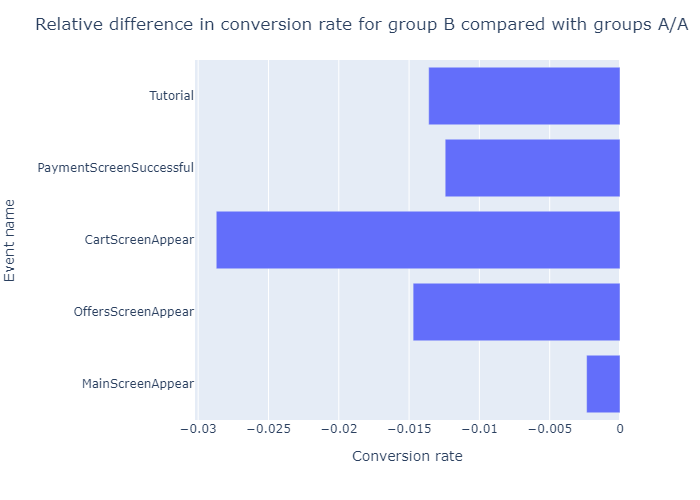

In [38]:
m_conversion = user_4.merge(user_3, left_on='event name', right_on='event name', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the conversion rate
fig =px.bar(m_conversion, y='event name', x=((m_conversion['conversionB'])/(m_conversion['conversionA'])-1)
           , orientation='h')
fig.update_layout(
    title='Relative difference in conversion rate for group B compared with groups A/A',
    xaxis_title="Conversion rate",
    yaxis_title="Event name")
fig.show("png");

#### Conclusions  of the A/A/B test

Out of the statistcal tests of proportions results and the relative difference in conversion rate graph, we can conclude that the font change was not sucessful. 

We found no statistically significant difference in conversion proportions between the A/A groups and the B group, and further more we can see the converation rates of the B group is relatively a bit smaller then the A/A groups.

#### Significance level  set to test the statistical hypotheses 

The significance level that was set to test the statistical hypotheses is the common 0.05 alpha value. 

Out of the high p-value results of the differnet z-tests we can see there is no reason to change the significance level to higher level , because even with 0.1 alpha value and even much higher values the test results would stay the same. 

# General conclusion

This report comes to investigate user behavior in the company's app that sells food products, and examine the results of an A/A/B test that checks the impact of changing the fonts for the entire app on the user behavior, in order to detrmine which set of fonts produces better results.

After analyzing the data, i came across some finding and conclusions i will show here.

Examing the users behavior on the app we can see there are 7551 users in the logs,
and the average number of events per user is 2.

Checking the sales funnel we can see that on the "Offers Screen Appear" stage we lose most of our users (38%  of the users), so it needs further investagtion to figure out what make the user leave between this stages.

We can also see that 47.7% of the users make the entire journey from "Main Screen Appear" stage to payment.


Out of the statistcal tests of proportions we conclude, we can see that:

1. There was no statistically significant difference in conversion proportions between the A/A groups. so we can confirm that the A/A groups were split properly.


2. There was no statistically significant difference in conversion proportions between A 246 and B groups.

   
3. There was no statistically significant difference in conversion proportions between A 247 and B groups.


4. There was no statistically significant difference in conversion proportions A/A combined groups and the B group.
   

 
Based on the test results, and the converation rates of the B group that is relatively a bit smaller then the A/A groups we can conclude that the change in the set of fonts on the app was not sucessful ,and not produces better results. 

